# Imports

In [1]:
import optuna
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.save_model import save_model


# Load Data

In [2]:
X, y = preprocess_data(load_data())

# Model

## Histogram Gradient Boosting Model

In [3]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
## Model
model = HistGradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[
    :, 1
]  # Probability estimates for the positive class (default)

In [5]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

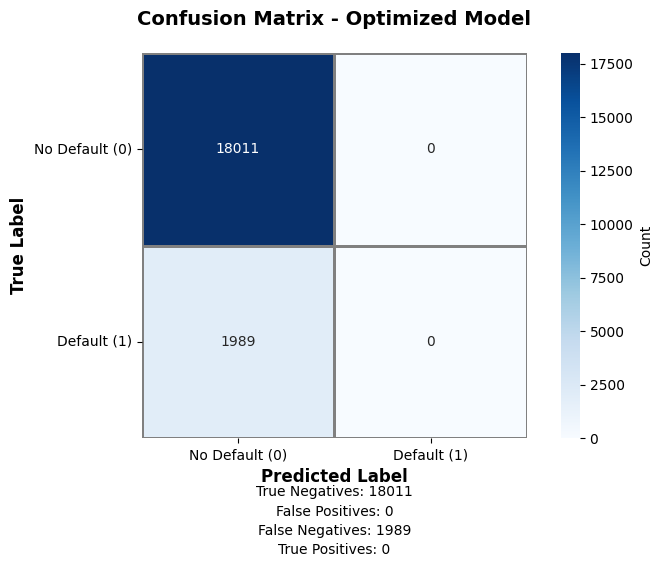


Model Metrics:
Accuracy:  0.9005 (90.05%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [6]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

## Hyperparameter fine-tuning (Optuna)

In [7]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.7)
    max_iter = trial.suggest_int("max_iter", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    # Create the model with suggested hyperparameters
    model = HistGradientBoostingClassifier(
        learning_rate=learning_rate,
        max_iter=max_iter,
        max_depth=max_depth,
        max_features=max_features,
        class_weight=class_weight,
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=500, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-15 22:45:12,711] A new study created in memory with name: no-name-7c0e170d-e1b7-4653-a1ec-ca0f5bbc0e1e


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-10-15 22:45:12,948] Trial 0 finished with value: 0.2530804987825574 and parameters: {'learning_rate': 0.12770696099770804, 'max_iter': 162, 'max_depth': 19, 'max_features': 0.7848547006948101, 'class_weight': 'balanced', 'threshold': 0.4094417753395784}. Best is trial 0 with value: 0.2530804987825574.
[I 2025-10-15 22:45:13,156] Trial 1 finished with value: 0.20221787345075015 and parameters: {'learning_rate': 0.1640411762447514, 'max_iter': 69, 'max_depth': 14, 'max_features': 0.591420708004965, 'class_weight': 'balanced', 'threshold': 0.738563048962085}. Best is trial 0 with value: 0.2530804987825574.
[I 2025-10-15 22:45:13,290] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.5136328910379768, 'max_iter': 351, 'max_depth': 34, 'max_features': 0.4111565117337983, 'class_weight': None, 'threshold': 0.6746592564526409}. Best is trial 0 with value: 0.2530804987825574.
[I 2025-10-15 22:45:13,452] Trial 3 finished with value: 0.20444212176639665 and parameters:

In [8]:
# Train the final model with best parameters
best_params = study.best_params

model = HistGradientBoostingClassifier(
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    max_depth=best_params["max_depth"],
    max_features=best_params["max_features"],
    class_weight=best_params["class_weight"],
)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_params["threshold"]).astype(int)

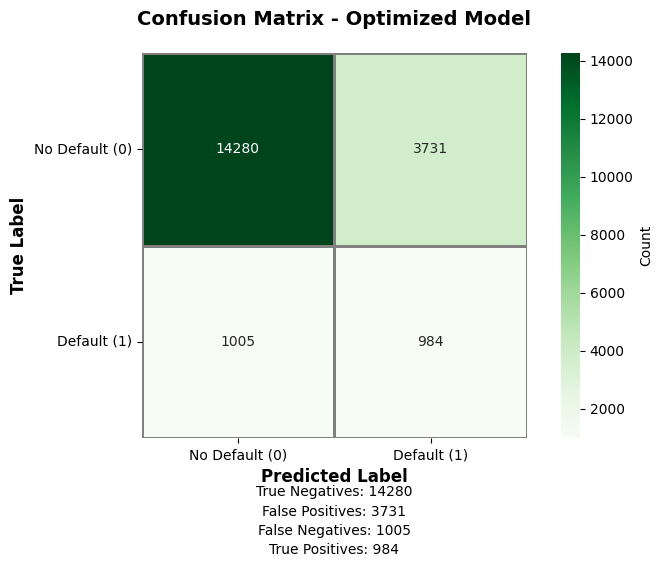


Model Metrics:
Accuracy:  0.7632 (76.32%)
Precision: 0.2087 (20.87%)
Recall:    0.4947 (49.47%)
F1-Score:  0.2936 (29.36%)


In [9]:
plot_confusion_matrix(y_test, y_pred, cmap="Greens")

In [10]:
compute_and_store_metrics(y_test, y_pred, model_name="Random Forest")

In [11]:
# Final training on the entire dataset
model = HistGradientBoostingClassifier(
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    max_depth=best_params["max_depth"],
    max_features=best_params["max_features"],
    class_weight=best_params["class_weight"],
)
model.fit(X, y)
save_model(model, model_name="hist_gradient_boosting")